In [1]:
%load_ext autoreload

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods import MLS
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler


2022-10-03 15:27:50.605841: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-03 15:27:50.701005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 15:27:50.701058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/pnovello/.virtualenvs/full/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Two datasets experiment

In [2]:
%autoreload 2
data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist')
ds2 = data_handler.load_tfds('fashion_mnist')
x_id = ds1["test"]
x_ood = ds2["test"]
x_train = ds1["train"]

x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=False)

2022-10-03 15:28:05.000848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 15:28:05.003211: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 15:28:05.004150: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-10-03 15:28:05.017006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 15:28:06.134039: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The call

In [9]:

model = get_model("../saved_models/mnist_model")

### MLS

79/79 [==============================] - 2s 24ms/step
716
{'auroc': 0.9947957849999999, 'fpr95tpr': 0.0207, 'accuracy_score': 0.9642, 'roc_auc_score': 0.99479567}


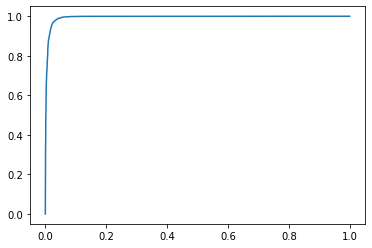

In [44]:

%autoreload 2
from sklearn.metrics import *

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)

metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()


### DKNN

2022-09-28 15:46:26.897599: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'auroc': 0.778035}


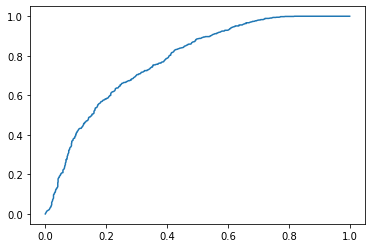

In [10]:
%autoreload 2

## This time need a dataset to fit KNN score
x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000))

oodmodel = DKNN()
oodmodel.fit(model, x_train.take(10000))
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [3]:
%autoreload 2
inc_labels = [0, 1, 2, 3, 4]
data_handler = DataHandler()
ds = data_handler.load_tfds('mnist')
x_id, x_ood = data_handler.filter_tfds(ds["test"], inc_labels = inc_labels )
x_train_id, _ = data_handler.filter_tfds(ds["train"], inc_labels = inc_labels )

In [4]:
%autoreload 2
from oodeel.models.training_funs import train_convnet

train_config = {
    "batch_size": 128,
    "epochs": 5
}

model = train_convnet(x_train_id, **train_config)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Epoch 1/5
240/240 [==============================] - 12s 44ms/step - loss: 0.2356 - accuracy: 0.9287
Epoch 2/5
240/240 [==============================] - 9s 37ms/step - loss: 0.0554 - accuracy: 0.9827
Epoch 3/5
240/240 [==============================] - 9s 36ms/step - loss: 0.0395 - accuracy: 0.9878
Epoch 4/5
240/240 [==============================] - 9s 38ms/step - loss: 0.0324 - accuracy: 0.9899
Epoch 5/5
240/240 [==============================] - 10s 42ms/step - loss: 0.0293 - accuracy: 0.9911


## MLS

{'auroc': 0.9429652812879906}


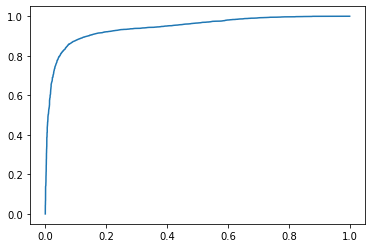

In [44]:
%autoreload 2


x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=False)

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### DKNN

{'auroc': 0.9385865}


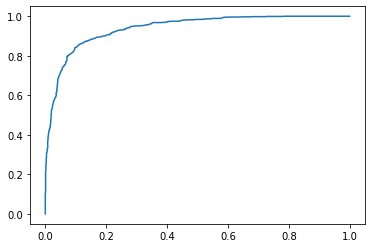

In [45]:
%autoreload 2

x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000))

oodmodel = DKNN()
oodmodel.fit(model, x_train_id.take(10000))
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()